<a href="https://colab.research.google.com/github/urwa-fatima/AdvanceMachineLearning_GNN/blob/main/GNN_AML_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESIGNING GRAPH NEURAL NETWORK (GNN)

Name: Urwa Fatima

## 1. Introduction
Graphs are powerful data structures that represent networks of entities and their relationships. While traditional neural networks excel at analyzing structured data such as images or text, they face limitations when dealing with complex, interconnected data, such as biological structures or social networks. Graph Neural Networks (GNNs) are designed to overcome these limitations, enabling the extraction of valuable insights from data best represented as graphs.



### 1.1 Limitations of Traditional Neural Networks
Elaborating on the limitations of traditional neural networks when dealing with graph-structured data


* **Variable-Sized Inputs**: Traditional neural networks, such as feedforward and convolutional networks, require fixed-size inputs. For example, CNNs expect images of a specific dimension, making it difficult to process graphs, which vary in size and structure.

* **Permutation Sensitivity**: The order in which nodes are presented affects the output of traditional networks. Since graphs lack an inherent order, changing the sequence of nodes in the input can lead to inconsistent predictions, which is undesirable when working with graph data.

* **Non-Euclidean Data**: Traditional neural networks work well with Euclidean data, like images or grids, where data points are organized in a regular structure. However, graph data exists in non-Euclidean space, meaning that relationships between nodes do not follow a regular grid, and distances are not uniform.

* **Homogeneous Input Assumptions**: Many traditional architectures assume that all input data is homogeneous, meaning that every data point has the same set of features. Graphs, however, are often heterogeneous, with nodes and edges having different attributes, making it difficult for traditional models to process such data.



### 1.2 Fundamental Idea of GNNs

The core concept behind Graph Neural Networks (GNNs) is representation learning for graph-structured data. GNNs learn to generate node embeddings by leveraging all available information, including node features, edges (connections between nodes), and edge features. These embeddings capture both the structural and feature-related information of the nodes. Once learned, these representations can be applied to various downstream tasks, such as prediction or classification. GNNs support three levels of tasks:


*   Node Level Classification
*   Edge Level Prediction
*   Graph Level Classification

<img src='https://drive.google.com/uc?export=view&id=1m9Ug-xBHxjzgtFKZhyaKJpzEX10cP_j6' width="370px">

### 1.3 Objective:
The focus of this project is to perform graph level classification. Given the supervised protien dataset, learn the function maping to classify the graphs as an Enzyme from non-Enzyme


In [ ]:
!pip install fsspec==2024.3.1

In [ ]:
!pip install --upgrade torch_geometric

In [ ]:
!pip install plotly

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter
import json
import os

In [ ]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


2.4.0+cu121


# 2. Dataset: PROTEINS (1113 Samples)
PROTEINS dataset, provided by [TU Dortmund](https://chrsmrrs.github.io/datasets/docs/datasets/) University, is used for graph classification tasks where the goal is to determine if a given protein is an enzyme or non-enzyme. The dataset consists of 1113 protein graphs, each representing an individual protein molecule. Of these, 450 proteins are labeled as enzymes, and 663 are labeled as non-enzymes.

**Dataset Overview**
* Number of graphs: 1113
* Number of classes: 2 (Enzyme vs. Non-enzyme)
* Number of node features: 3 (Representing secondary structural elements - helices, sheets, and turns)
* Number of edges: Varies by graph (Average: 72.82 edges per graph)
* Number of edge features: 0 (No edge attributes are present)
* Average number of nodes per graph: 39.06
* Graph structure: Undirected, no self-loops or isolated nodes

**Node Representation**

Each protein is represented as a graph, where nodes correspond to secondary structure elements (SSEs) within the protein, such as helices, sheets, and turns. These are the building blocks of a protein’s secondary structure—a critical aspect of how proteins fold and function. Each node has one of the following labels:

* Helices: [1, 0, 0]
* Sheets: [0, 1, 0]
* Turns: [0, 0, 1]

<img src='https://drive.google.com/uc?export=view&id=14ja34zI9HUfVH-Xj-DZ7U1qoaWxPuxTI' width="400px">

**Edge Representation**

Edges in the graphs are determined by two main relationships:

*Sequential Edges*: Connect nodes that are neighbors in the amino acid sequence.

*Spatial Edges*: Connect nodes that are spatially close in the 3D structure of the protein. Each node is connected to its three nearest neighbors in space.

These edges represent the structural and sequential relationships within the protein, but the dataset contains no additional edge attributes.

<img src='https://drive.google.com/uc?export=view&id=1OjaBH1qpgiDoxOxspbbBLggaHlLgqee-' width="600px">

Fig: Schematic illustration of graph generation from PDB protein file (Berman et al., 2000) (circles, SSEs; thin dashed lines, sequential edges; thick solid lines, structural edges).

(Borgwardt et al., Protein function prediction via graph kernels 2005)

### 2.1 Biological Context
Protein structure is organized into several hierarchical levels:

* Primary structure: The linear sequence of amino acids in the protein.

* Secondary structure: Local folded structures, such as helices, sheets, and turns, within the protein. This dataset focuses on this level of structure.

* Tertiary structure: The overall 3D shape of a single protein molecule.

* Quaternary structure: The arrangement of multiple protein molecules that function together as a unit.

In this dataset, only the secondary structure is captured and represented in the form of node labels. These secondary structures (helices, sheets, and turns) are determined by patterns of hydrogen bonding between amino acids, and they play a crucial role in defining the protein's 3D structure, folding behavior, interactions, and functions.

### 2.2 **Version of the Dataset**

There are two versions of the PROTEINS dataset:

Simplified version: Includes only secondary structure elements (helices, sheets, and turns) as node features, without additional chemical or physical properties. This version is being used in the current project.

Full version: Contains detailed chemical and physical properties for each node. This version is more complex but is not being used in this study.

<img src='https://drive.google.com/uc?export=view&id=1u9lQ17ltb7WGUPUlrw2dLoQFZ2JK4WmR' width="500px">


### 2.3 Representing Graphs to be Compatible with Neural Networks
Graphs can be represented in two common ways: as an adjacency matrix or as an adjacency list. The adjacency matrix is a square matrix where each entry represents whether a pair of nodes is connected by an edge. This is especially useful for dense graphs where most nodes are connected. However, for large, sparse graphs—such as the ones often encountered in real-world and datasets like our protein dataset—the adjacency matrix contains mostly zero values, making it memory-inefficient.

In PyTorch, sparse matrices like graph adjacency matrices are efficiently represented using the COO (Coordinate) format. This format only stores non-zero values and their indices, reducing memory usage for sparse graphs.

In [ ]:
dataset = TUDataset(root='PROTEINS', name='PROTEINS')


Processing...
Done!


In [ ]:
# Overview of the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') # num_features and num_node_features is the same thing
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print("First Protein Graph:", data)
print('=========================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of edge feature: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Edges in COO format: {data.edge_index}')
print(f'Label: {data.y}')
print(f'Node features: {data.x}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

First Protein Graph: Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of node features: 3
Number of edges: 162
Number of edge feature: 0
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Edges in COO format: tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,
          9,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13,
         14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 22,
         23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28,
         28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32,
         33, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 3

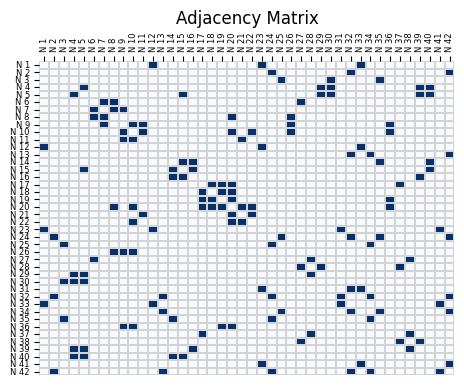

In [ ]:
# A dense adjacency matrix from a sparse edge index
adjacency_matrix = torch.sparse_coo_tensor(
    indices=data.edge_index,
    values=torch.ones(data.edge_index.size(1)),  # Setting edge weights to 1
    size=(data.num_nodes, data.num_nodes)  # Number of nodes
)

# Convert sparse COO tensor to dense adjacency matrix
dense_adj_matrix = adjacency_matrix.to_dense()
node_labels = [f'N {i+1}' for i in range(data.num_nodes)]
# Plot the adjacency matrix as a heatmap
plt.figure(figsize=(5, 4))
plot = sns.heatmap(dense_adj_matrix, annot=False, cmap="Blues",
            xticklabels=node_labels,
            yticklabels=node_labels,
            cbar=False, linewidths=0.2, linecolor='lightgray')

# Move x-axis labels to the top and adjust layout
plt.gca().xaxis.tick_top()
plt.setp(plot.get_xticklabels(), rotation=90)
# Set font size for x and y tick labels
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=6)
plt.tight_layout(pad=2)

plt.title("Adjacency Matrix")
plt.show()

In [ ]:
# class distribution in our dataset
enzymes = 0
non_enzymes = 0

for data in dataset:
  if data.y.item() == 1:
    enzymes += 1
  else:
    non_enzymes += 1

print(f"Number of enzymes: {enzymes}")
print(f"Number of non-enzymes: {non_enzymes}")


Number of enzymes: 450
Number of non-enzymes: 663


In [ ]:
# checking proteins with SSE of turns in proteins
indices = []
for i in range(len(dataset)):
  data = dataset[i]
  for j in range(data.x.shape[0]):
    if torch.all(data.x[j] == torch.tensor([0, 0, 1])):
      indices.append(i)
      break
print(len(indices))
print(indices)


88
[25, 36, 42, 123, 125, 168, 170, 232, 240, 305, 311, 313, 321, 343, 351, 353, 354, 410, 415, 419, 420, 424, 431, 433, 446, 453, 454, 507, 523, 537, 547, 554, 555, 563, 570, 581, 583, 587, 614, 615, 617, 621, 628, 639, 641, 642, 643, 653, 655, 656, 685, 727, 745, 750, 753, 755, 756, 765, 799, 831, 861, 885, 934, 936, 957, 969, 973, 980, 1018, 1029, 1030, 1041, 1050, 1057, 1061, 1063, 1066, 1072, 1074, 1076, 1080, 1085, 1089, 1092, 1098, 1109, 1110, 1112]


In [ ]:
data = dataset[523]
data

Data(edge_index=[2, 72], x=[21, 3], y=[1])

In [ ]:
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

# Compute a fixed layout
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

node_colors = ['tab:red' if f[0] > 0 else 'tab:blue' if f[1] > 0 else 'orange' for f in data.x]
pred_node_colors = ['tab:green' if p > 0 else 'tab:gray' for p in data.y]


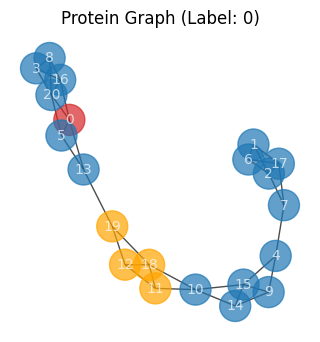

In [ ]:
# Draw the graph
plt.figure(figsize=(3, 3))
nx.draw(G, pos=pos, node_color=node_colors, with_labels=True, node_size=500, font_size=10, font_color="white", alpha=0.7,)
plt.title(f"Protein Graph (Label: {data.y.item()})")
plt.show()

# 3. Data Spliting and Batching

Proper data splitting is crucial for developing robust machine learning models, particularly when dealing with imbalanced datasets such as the PROTEINS dataset. The dataset contains 1,113 protein samples, with 450 labeled as enzymes and 663 labeled as non-enzymes. Two sampling methods were explored to split the imbalanced dataset:


1.   Random Sampling
2.   Stratified Sampling

**Random Sampling**

Random sampling involves assigning data points randomly to the training, validation, and test sets. This method is straightforward and effective for large, balanced datasets. However, in the case of smaller or imbalanced datasets, it can result in uneven class distribution across splits, leading to non-representative subsets.


>**Random Sampling** | Total Samples |Enzymes| Non-Enzymes
>-------------------|------------------|-----------|---------
>Training       | 779 |321 | 458
>Validation       | 166 | 65| 101
>Test       | 168 | 64 | 104

**Stratified Sampling**

Stratified sampling ensures that the proportion of samples for each class is maintained across the training, validation, and test sets, reflecting the overall class distribution in the dataset. This method helps reduce bias in model evaluation, making it particularly useful for imbalanced datasets. Although stratified sampling is more complex to implement, it ensures that class proportions are preserved across all splits, leading to more balanced datasets. However, it may not capture other important dataset characteristics beyond class distribution.



>**Stratified  Sampling** | Total Samples |Enzymes| Non-Enzymes
>-------------------|------------------|-----------|---------
>Training       | 779 |315 | 464
>Validation       | 167 | 67| 100
>Test       | 167 | 68 | 99




Random sampling resulted in greater variance in the enzyme vs. non-enzyme distribution across the splits. For example, the test set exhibited a larger imbalance, with 64 enzymes and 104 non-enzymes. In contrast, stratified sampling effectively preserved the original class ratio across the training, validation, and test sets. The enzyme and non-enzyme counts were more balanced, reducing differences across the sets.

Given the advantages of stratified sampling in preserving class balance, this method was selected for data splitting in the project to ensure consistent and representative subsets for model training, validation, and testing.

In [ ]:
def check_class_distribution(dataset):
  # Count the number of enzymes and non-enzymes in the dataset
  enzymes = sum(data.y.item() == 1 for data in dataset)
  non_enzymes = len(dataset) - enzymes
  return enzymes, non_enzymes

In [ ]:
# dataset = dataset.shuffle()
num_training = int(len(dataset) * 0.7)
num_val = int(len(dataset) * 0.15)
num_test = len(dataset) - (num_training + num_val)
# Split the dataset
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test], generator=torch.Generator().manual_seed(42))

# Get class distribution for each set of the random split data
train_enzymes, train_non_enzymes = check_class_distribution(training_set)
val_enzymes, val_non_enzymes = check_class_distribution(validation_set)
test_enzymes, test_non_enzymes = check_class_distribution(test_set)

print(f"Training set Total: {len(training_set)} - Enzymes: {train_enzymes}, Non-Enzymes: {train_non_enzymes}")
print(f"Validation set Total: {len(validation_set)} - Enzymes: {val_enzymes}, Non-Enzymes: {val_non_enzymes}")
print(f"Test set Total: {len(test_set)} - Enzymes: {test_enzymes}, Non-Enzymes: {test_non_enzymes}")

Training set Total: 779 - Enzymes: 321, Non-Enzymes: 458
Validation set Total: 166 - Enzymes: 65, Non-Enzymes: 101
Test set Total: 168 - Enzymes: 64, Non-Enzymes: 104


In [ ]:
# split using stratified sampling method
from sklearn.model_selection import train_test_split

labels = [data.y for data in dataset]

# Stratified split into train and temp (for validation + test)
train_idx, temp_idx = train_test_split(range(len(labels)),
                                       test_size=0.3,
                                       stratify=labels)

# Further stratified split into validation and test
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])

# Create train, val, test sets
train_data = dataset[train_idx]
val_data = dataset[val_idx]
test_data = dataset[test_idx]

In [ ]:
train_enzymes, train_non_enzymes = check_class_distribution(train_data)
val_enzymes, val_non_enzymes = check_class_distribution(val_data)
test_enzymes, test_non_enzymes = check_class_distribution(test_data)

print(f"Training set Total: {len(train_data)} - Enzymes: {train_enzymes}, Non-Enzymes: {train_non_enzymes}")
print(f"Validation set Total: {len(val_data)} - Enzymes: {val_enzymes}, Non-Enzymes: {val_non_enzymes}")
print(f"Test set Total: {len(test_data)} - Enzymes: {test_enzymes}, Non-Enzymes: {test_non_enzymes}")

Training set Total: 779 - Enzymes: 315, Non-Enzymes: 464
Validation set Total: 167 - Enzymes: 68, Non-Enzymes: 99
Test set Total: 167 - Enzymes: 67, Non-Enzymes: 100


## 3.1 Mini-Batching
After splitting the data, batching is essential for efficient training. It enables:

* Parallel processing of multiple samples
* Memory-efficient training on large datasets
* Improved generalization through noisier gradient estimates

In PyTorch Geometric, batching is achieved by stacking adjacency matrices diagonally to form a large graph with isolated subgraphs, while node and target features are concatenated. This is handled by the torch_geometric.data.DataLoader class.

In [17]:
# Creating DataLoader for training, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [18]:
#testing the datalaoder
first_batch = next(iter(train_loader))
# Get the node indices corresponding to the first protein in the first batch of train loader
graph_index = 0
protein_node_indices = (first_batch.batch == graph_index).nonzero(as_tuple=True)[0]
protein_x = first_batch.x[protein_node_indices]  # Node features for the first protein
protein_edge_index = first_batch.edge_index[:, (first_batch.batch[first_batch.edge_index[0]] == graph_index)]  # Edges for the first protein
protein_label = first_batch.y[graph_index]  # Label for the first protein
# Print the extracted graph information
print("Node features (x) for first protein graph:")
print(protein_x)

print("\nEdge index for first protein graph:")
print(protein_edge_index)

print("\nLabel (y) for first protein graph:")
print(protein_label)

Node features (x) for first protein graph:
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

Edge index for first protein graph:
tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  5,
          5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
         10, 10],
        [ 6,  7,  8,  6,  7,  9,  3,  9, 10,  2,  4,  5,  9, 10,  3,  5, 10,  3,
          4, 10,  0,  1,  7,  8,  0,  1,  6,  8,  0,  6,  7,  1,  2,  3,  2,  3,
          4,  5]])

Label (y) for first protein graph:
tensor(0)


# 4. GNN Model Training

Reference: [Pytorch graph classicification tutorial  ](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=G-DwBYkquRUN)


Graph Neural Networks (GNNs) capture the dependencies between nodes by leveraging message passing and aggregation functions, making them suitable for applications such as social network analysis and molecular graph classification.

In this project, two distinct GNN models were implemented: a Graph Convolutional Network (GCN) and a Recurrent GNN, based on Scarselli's 2009 paper. Both models perform graph classification but differ in their approach to message passing. Below, we describe the general pipeline of a GNN and then compare the two models.

* **Graph Representation:** A graph is represented as $G=(V,E)$, where V represents the set of nodes and E represents the set of edges. Each node $v ∈ V$ is associated with a feature vector $h_{v}$.

* **Message Passing**: Message passing is a two-step process where nodes exchange information with their neighbors. The node u's updated embedding after message passing is defined as:

$$ h^{(k+1)}_{u} = UPDATE^{(k)}(h^{(k)}_{u}, AGGREGATE(\{h^{(k)}_{u}, \forall v \in N(u)\}))$$

  <center>
  Where $h^{(k)}_{u}$ is the node embedding at the k-th layer and
  $N(u)$ represents the neighbors of node u. </center>


* **Aggregation**: The aggregation function collects information from neighboring nodes. This function must be permutation invariant, and common aggregation methods include summation, mean, and max pooling.

* **Node Embedding Update**: After aggregation, each node's feature vector is updated using a transformation, often including a non-linearity like ReLU.

* **Global Pooling (Readout)**: To produce a graph-level embedding from node embeddings, a global pooling operation (mean pooling, max pooling) is applied. This pooling operation is essential for graph-level tasks like classification.

* **Prediction**: The graph-level embedding is passed through a classifier, typically a fully connected (linear) layer, to predict the output for the task (e.g., classifying a graph as enzyme or non-enzyme).

<center><img src='https://drive.google.com/uc?export=view&id=1ChxO9aXxQQWvzPcYtTWCbmLgU5ABCZ0h' width="600px"></center>

### GCN Model
The Graph Convolutional Network (GCN) used in this project consists of three GCNConv layers, followed by a global mean pooling layer and a final linear layer for classification. This model utilizes message passing formulated as matrix multiplication between the normalized adjacency matrix and the node feature matrix.

*Message Passing*: The GCNConv layer multiplies the normalized adjacency matrix
${A}̃$ by the node features.
$$X^{(l+1)} = σ(D^{−1/2}ÃD^{−1/2}X^{(l)}W^{(l)})$$
where

$X^{(l+1)}$ is the node embeddings after the convolution.

$Ã$ is the adjacency matrix with added self-loops.

$D$ is the degree matrix.

$X^{(l)}$ is the node embeddings before the convolution.

$W^{(l)}$ is the layer’s weight matrix.

$σ$ is the activation function (ReLU in this case).

*Aggregation*: The sum aggregation is used to gather information from neighbors.

*Global Pooling*: Global mean pooling reduces the node embeddings into a graph-level embedding by averaging the node embeddings, followed by a linear classifier.
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

### Recurrent GNN Model
The Recurrent GNN follows the iterative approach proposed in Scarselli’s 2009 paper. This model performs message passing iteratively over 50 layers, allowing node embeddings to gradually evolve. Each iteration is followed by a transition layer implemented as a Multi-Layer Perceptron (MLP). The final graph embedding is obtained through global pooling, with the readout layer also implemented as an MLP.

*Message Passing*: The model repeatedly updates node embeddings based on neighboring nodes' information. This iterative process reflects the method used in early GNNs.

*Transition Layer*: After each message passing step, an MLP transforms the node embeddings.

*Global Pooling*: After 10 iterations, mean pooling is applied to generate the graph-level embedding.

Differences in Models:
Earlier Graph Neural Networks, such as those proposed by Scarselli et al. in 2009, used an iterative approach to update node representations. Node states were initialized and repeatedly updated based on neighbor information until convergence or a set number of iterations. In contrast, Graph Convolutional Networks (GCNs) introduced a fixed number of layers, where each layer aggregates information from neighboring nodes in a single step. The key update rule in GCNs involves multiplying the node feature matrix by a normalized adjacency matrix and a learnable weight matrix, followed by a non-linear activation.


In [12]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
class EarlyStopping:
    def __init__(self, patience=20, delta=0):
        """
        Arguments:
        patience: Number of epochs to wait after no improvement.
        delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_f1 = 0

    def __call__(self, val_f1, model, optimizer, epoch, save_path='checkpoint.pth'):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model, optimizer, epoch, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model, optimizer, epoch, save_path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, optimizer, epoch, save_path):
        """Saves model when validation F1 score improves."""
        print(f'Validation F1 score improved to {val_f1:.4f}, saving model...')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, save_path)


In [15]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

In [19]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Training loop
model = GCN(hidden_channels=64).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []


# Variables to save the best model
best_val_f1 = 0  # Tracking best validation F1 score
best_model_path = 'best_gnn_model_f1.pth'  # Path to save the best model

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_train_preds = []
    all_train_labels = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # predictions and labels for F1 score calculation for training
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(data.y.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Calculate training F1 score
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_f1_scores.append(train_f1)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            val_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

            # predictions and labels for F1 score calculation
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(data.y.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculating validation F1 score
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    val_f1_scores.append(val_f1)

    # Printing training and validation results
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

    # Early stopping
    early_stopping(val_f1, model, optimizer, epoch, save_path='best_model_f1.pth')
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# After training is done, load the best model based on F1 score
checkpoint = torch.load('best_model_f1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Loaded the best model from epoch {checkpoint['epoch']+1} with validation F1 score {checkpoint['val_f1']:.4f}")

# Testing (after training is complete)
model.eval()
test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        test_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # Collect predictions and labels for F1 score calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total
test_f1 = f1_score(all_labels, all_preds, average='weighted')  # weighted F1 score for test set

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')


<IPython.core.display.Javascript object>

Epoch [1/100], Train Loss: 0.6883, Train Acc: 0.5494, Train F1: 0.5348, Val Loss: 0.6663, Val Acc: 0.5928, Val F1: 0.4413
Validation F1 score improved to 0.4413, saving model...
Epoch [2/100], Train Loss: 0.6708, Train Acc: 0.5956, Train F1: 0.4447, Val Loss: 0.6571, Val Acc: 0.5928, Val F1: 0.4413
Epoch [3/100], Train Loss: 0.6709, Train Acc: 0.5956, Train F1: 0.4602, Val Loss: 0.6487, Val Acc: 0.6287, Val F1: 0.5254
Validation F1 score improved to 0.5254, saving model...
Epoch [4/100], Train Loss: 0.6634, Train Acc: 0.6136, Train F1: 0.5012, Val Loss: 0.6368, Val Acc: 0.6347, Val F1: 0.5567
Validation F1 score improved to 0.5567, saving model...
Epoch [5/100], Train Loss: 0.6490, Train Acc: 0.6303, Train F1: 0.5506, Val Loss: 0.6198, Val Acc: 0.6347, Val F1: 0.5782
Validation F1 score improved to 0.5782, saving model...
Epoch [6/100], Train Loss: 0.6477, Train Acc: 0.6470, Train F1: 0.5908, Val Loss: 0.6093, Val Acc: 0.6707, Val F1: 0.6471
Validation F1 score improved to 0.6471, savi

<ipython-input-19-763eda828c1c>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_f1.pth')


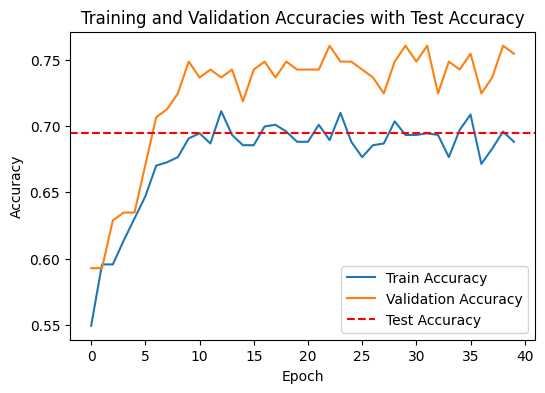

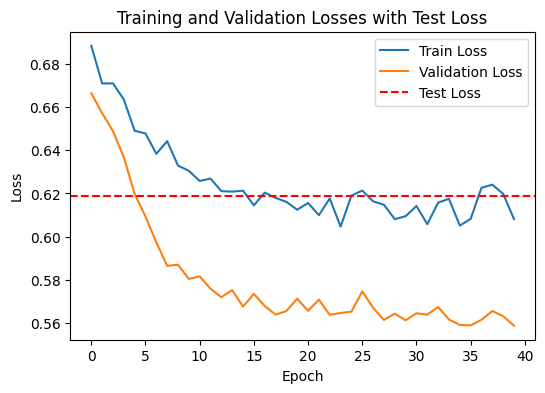

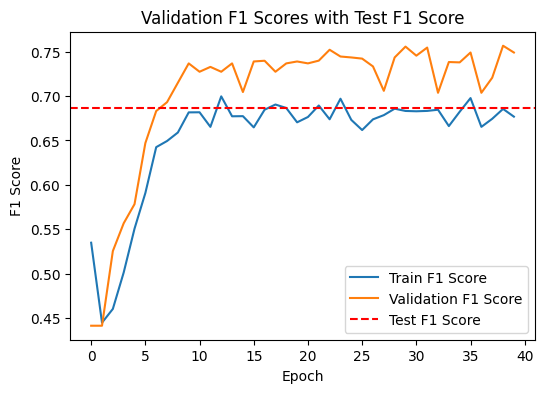

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Plotting test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies with Test Accuracy')
plt.legend()
plt.show()

# Plot the training and validation losses
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Plotting test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses with Test Loss')
plt.legend()
plt.show()

# Plot validation F1 scores
plt.figure(figsize=(6, 4))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')  # Plotting test F1 score as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Scores with Test F1 Score')
plt.legend()
plt.show()

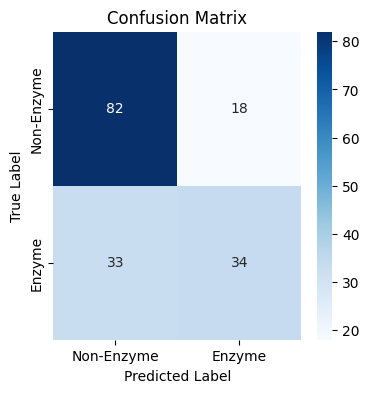

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Enzyme', 'Enzyme'],
            yticklabels=['Non-Enzyme', 'Enzyme'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




---



---



## RGNN Model

Reference: [Recurrent Graph Neural Network](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial9/RecGNN_tutorial.ipynb)

In [22]:
from torch.nn import Parameter as Param
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import global_mean_pool

In [23]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, out_dim):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential()
        dims = [input_dim] + hid_dims + [out_dim]
        for i in range(len(dims)-1):
            self.mlp.add_module('lay_{}'.format(i),nn.Linear(in_features=dims[i], out_features=dims[i+1]))
            if i+2 < len(dims):
                self.mlp.add_module('act_{}'.format(i), nn.Tanh())
    def reset_parameters(self):
        for i, l in enumerate(self.mlp):
            if type(l) == nn.Linear:
                nn.init.xavier_normal_(l.weight)

    def forward(self, x):
        return self.mlp(x)

In [24]:
class GNNM(MessagePassing):
    def __init__(self, in_channels, out_channels, features_dim, hid_dims, num_layers=10, eps=1e-3, aggr='add', bias=True, **kwargs):
        super(GNNM, self).__init__(aggr=aggr, **kwargs)

        self.eps = eps
        self.num_layers = num_layers

        # MLP for transition between message-passing layers
        self.transition = MLP(features_dim, hid_dims, features_dim)

        # MLP for readout after pooling (graph-level embedding)
        self.readout = MLP(features_dim, hid_dims, out_channels)

        self.reset_parameters()
        print(self.transition)
        print(self.readout)

    def reset_parameters(self):
        self.transition.reset_parameters()
        self.readout.reset_parameters()

    def forward(self, data):
        # Graph input: batch of graphs
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for _ in range(self.num_layers):
            x = self.propagate(edge_index, x=x)  # Message passing
            x = self.transition(x)  # Apply MLP for transition

        # Global pooling: aggregate node embeddings into graph-level embeddings
        graph_embedding = global_mean_pool(x, batch)  # Batch-wise mean pooling of node embeddings

        # Final MLP for graph classification
        out = self.readout(graph_embedding)

        return F.log_softmax(out, dim=-1)  # Return log-softmax of graph-level prediction

    def message(self, x_j):
        return x_j  # Simple message passing, no edge features used in this case

    def __repr__(self):
        return '{}(in_channels={}, out_channels={}, num_layers={})'.format(self.__class__.__name__, self.in_channels, self.out_channels, self.num_layers)


In [26]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GNNM(
    in_channels=dataset.num_features,     # Number of input features per node
    out_channels=dataset.num_classes,     # Number of graph-level classes (2 for binary classification, etc.)
    features_dim=dataset.num_features,    # feature size for each node
    hid_dims=[64, 64],                    # Hidden dimensions of MLPs
    num_layers=3,                         # Number of message-passing layers
    eps=0.01                              # Convergence threshold for node state updates (optional)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []


# Variables to save the best model
best_val_f1 = 0  # Tracking best validation F1 score
best_model_path = 'best_gnn_model_f1.pth'  # Path to save the best model

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_train_preds = []
    all_train_labels = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # predictions and labels for F1 score calculation for training
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(data.y.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Calculate training F1 score
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_f1_scores.append(train_f1)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            val_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

            # predictions and labels for F1 score calculation
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(data.y.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculating validation F1 score
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    val_f1_scores.append(val_f1)

    # Printing training and validation results
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

    # Early stopping
    early_stopping(val_f1, model, optimizer, epoch, save_path='best_model_f1.pth')
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# After training is done, load the best model based on F1 score
checkpoint = torch.load('best_model_f1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Loaded the best model from epoch {checkpoint['epoch']+1} with validation F1 score {checkpoint['val_f1']:.4f}")

# Testing (after training is complete)
model.eval()
test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        test_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # Collect predictions and labels for F1 score calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total
test_f1 = f1_score(all_labels, all_preds, average='weighted')  # weighted F1 score for test set

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')


<IPython.core.display.Javascript object>

MLP(
  (mlp): Sequential(
    (lay_0): Linear(in_features=3, out_features=64, bias=True)
    (act_0): Tanh()
    (lay_1): Linear(in_features=64, out_features=64, bias=True)
    (act_1): Tanh()
    (lay_2): Linear(in_features=64, out_features=3, bias=True)
  )
)
MLP(
  (mlp): Sequential(
    (lay_0): Linear(in_features=3, out_features=64, bias=True)
    (act_0): Tanh()
    (lay_1): Linear(in_features=64, out_features=64, bias=True)
    (act_1): Tanh()
    (lay_2): Linear(in_features=64, out_features=2, bias=True)
  )
)
Epoch [1/100], Train Loss: 0.6881, Train Acc: 0.5892, Train F1: 0.5375, Val Loss: 0.6668, Val Acc: 0.5928, Val F1: 0.4413
Validation F1 score improved to 0.4413, saving model...
Epoch [2/100], Train Loss: 0.6789, Train Acc: 0.5494, Train F1: 0.5054, Val Loss: 0.6367, Val Acc: 0.5928, Val F1: 0.4413
Epoch [3/100], Train Loss: 0.6334, Train Acc: 0.6483, Train F1: 0.6022, Val Loss: 0.6021, Val Acc: 0.6707, Val F1: 0.6694
Validation F1 score improved to 0.6694, saving model..

<ipython-input-26-71e85ce34660>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_f1.pth')


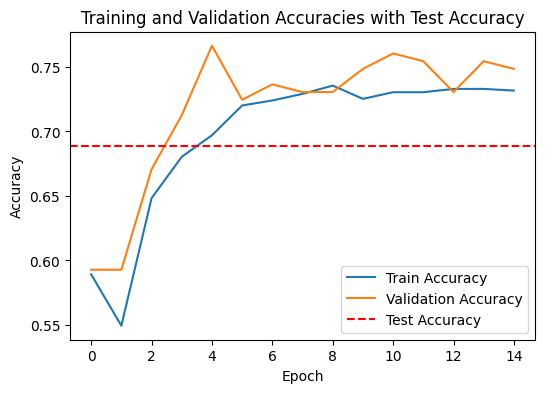

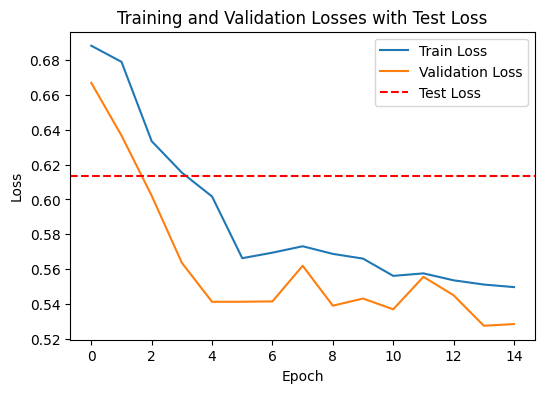

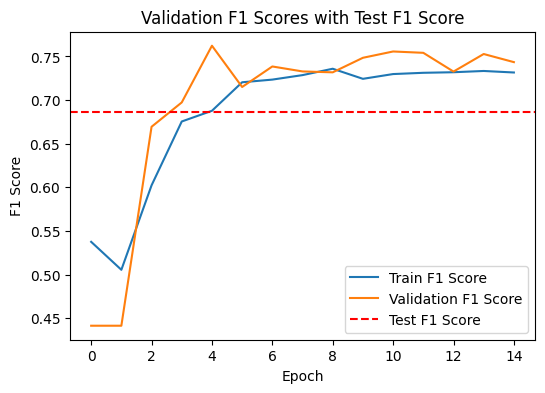

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Plotting test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies with Test Accuracy')
plt.legend()
plt.show()

# Plot the training and validation losses
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Plotting test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses with Test Loss')
plt.legend()
plt.show()

# Plot validation F1 scores
plt.figure(figsize=(6, 4))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')  # Plotting test F1 score as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Scores with Test F1 Score')
plt.legend()
plt.show()

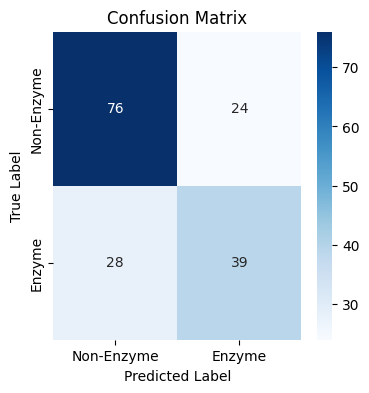

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Enzyme', 'Enzyme'],
            yticklabels=['Non-Enzyme', 'Enzyme'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



---



---



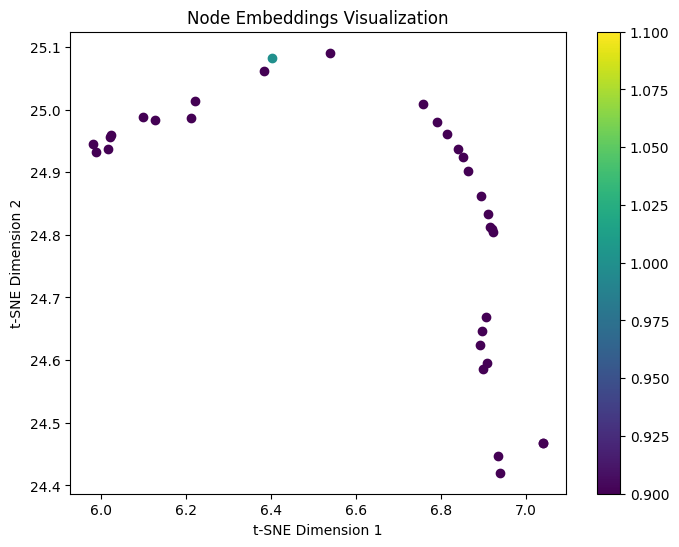

In [32]:
def visualize_node_embeddings(model, loader, device):
  """
  Visualizes node embeddings of a graph dataset using t-SNE.

  Args:
    model: The trained GNN model.
    loader: DataLoader for the dataset.
    device: The device to use (e.g., 'cuda' or 'cpu').
  """
  model.eval()
  with torch.no_grad():
    for data in loader:
      data = data.to(device)
      out = model(data)  # Get node embeddings
      break  # Take the first batch for visualization

  # Use t-SNE to reduce dimensionality of embeddings
  from sklearn.manifold import TSNE
  tsne = TSNE(n_components=2, random_state=42)
  embeddings_2d = tsne.fit_transform(out.cpu().numpy())

  # Plot the embeddings
  plt.figure(figsize=(8, 6))
  for i in range(data.y.size(0)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=data.y[i].item(), cmap='viridis')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.title('Node Embeddings Visualization')
  plt.colorbar()
  plt.show()

# Example usage:
visualize_node_embeddings(model, test_loader, device)
